# **The Stokes equations - adaptive mesh refinement**
**Johan Hoffman**

**Parasuram I V L N**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [211]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [212]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1,\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

The domain generation is similar to Lab 1

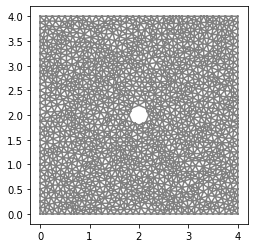

In [213]:
# Define rectangular domain 
L = 4
H = L

# Define circle
xc = 0.5*L
yc = 0.5*H
rc = 0.2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
init_no_levels = 0
for i in range(0,init_no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

Similar to Lab 1. However, here, additionally finite element spaces are generated for the adjoint equations as well.

In [214]:
# Generate mixed finite element spaces (for primal velocity and pressure)
VE = VectorElement("CG", mesh.ufl_cell(), 2)
QE = FiniteElement("CG", mesh.ufl_cell(), 1)
WE = VE * QE

W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE)

# Define trial and test functions
w = Function(W)
(u, p) = (as_vector((w[0],w[1])), w[2])
(v, q) = TestFunctions(W) 

# Generate mixed finite element spaces (for adjoint velocity and pressure)
VEa = VectorElement("CG", mesh.ufl_cell(), 6)
QEa = FiniteElement("CG", mesh.ufl_cell(), 5)
WEa = VEa * QEa

Wa = FunctionSpace(mesh, WEa)
Va = FunctionSpace(mesh, VEa)
Qa = FunctionSpace(mesh, QEa)

# Define adjoint trial and test functions
wa = Function(Wa)
(phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
(va, qa) = TestFunctions(Wa)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Define boundary conditions**

In [215]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define and solve variational problems**

In [216]:
# Set boundary penalty parameter gamma 
h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h

# Set force in primal problem
f = Expression(("0.0","0.0"), element = V.ufl_element())

# Set data that describe functional that defines the adjoint problem
#psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
#psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())
psi1 = Expression(("0.0","1.0"), element = V.ufl_element())
psi2 = Expression("0.0", element = Q.ufl_element())
phi3 = Expression(("1.0","0.0"), element = V.ufl_element())

# Define primal variational problem on residual form: r(u,p;v,q) = 0
res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
        gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

# Solve primal algebraic system 
solve(res == 0, w) 

# Define adjoint variational problem on residual form: r(u,p;v,q) = 0
res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
          gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - phi3, va))*ds 
         - inner(va, psi1)*dx - qa*psi2*dx )

# Solve adjoint algebraic system 
solve(res_a == 0, wa) 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


**Visualize solution and export files**

rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


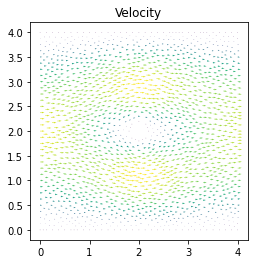

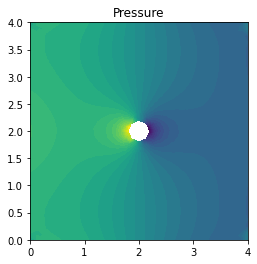

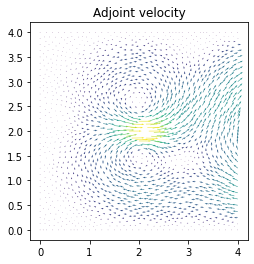

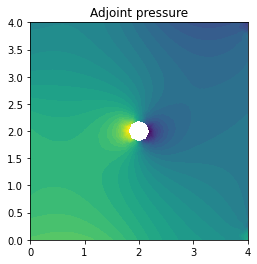

In [217]:
!rm results-NS/*

# Open files to export solution to Paraview
file_u = File("results-Stokes/u.pvd")
file_p = File("results-Etokes/p.pvd")
file_phi = File("results-Stokes/phi.pvd")
file_theta = File("results-Etokes/theta.pvd")

# Initiate functions to save and visualize the solutions
u_fcn = project(u, V)
p_fcn = project(p, Q)
phi_fcn = project(phi, V)
theta_fcn = project(theta, Q)

# Save solution to file
file_u << u_fcn
file_p << p_fcn
file_phi << phi_fcn
file_theta << theta_fcn

# Plot solution
plt.figure()
plot(u_fcn, title="Velocity")

plt.figure()
plot(p_fcn, title="Pressure")

plt.figure()
plot(phi_fcn, title="Adjoint velocity")

plt.figure()
plot(theta_fcn, title="Adjoint pressure")
        
plt.show()

# Export files
#!tar -czvf results-Stokes.tar.gz results-NS
#files.download('results-Stokes.tar.gz')

**Compute error indicators**

Calling FFC just-in-time (JIT) compiler, this may take some time.


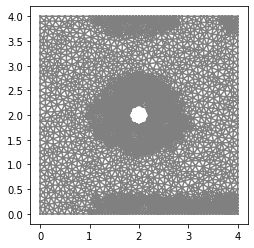

Calling FFC just-in-time (JIT) compiler, this may take some time.
Total error = 0.014212570228276692


In [218]:
# Define function space over the elements of the mesh
WDG = FunctionSpace(W.mesh(), "DG", 0)
elm = TestFunction(WDG)
err_ind = Function(WDG)

# Compute local error indicators over the cells of the mesh 
local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
err_ind.vector()[:] = assemble(local_error)
err_ind_abs = np.abs(err_ind.vector())
err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for c in cells(mesh):
    cell_marker[c] = False
    local_error_cell = err_ind_abs[c.index()] 
    if local_error_cell > err_ind_mean:
        cell_marker[c] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
               gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

tot_err = assemble(err_ind_sum)
s = 'Total error = ' + repr(tot_err) 
print(s)

# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

Initial case

[Mesh](https://drive.google.com/file/d/1UtYBZcKpyLAJ5AqTLPuN4JE_v5QpKGKn/view?usp=sharing), [Velocity](https://drive.google.com/file/d/1B09mP9qbXKUbXtGyk3SeqVd-axGjq92v/view?usp=sharing), [Pressure](https://drive.google.com/file/d/1Am3n8HCFO7d7Cm5dCJrfORk0Mn1Pvyup/view?usp=sharing), [Adjoint Velocity](https://drive.google.com/file/d/1W_QropYEh7dsFZG6SEZ7DX2-1p0Arxgj/view?usp=sharing), [Adjoint Pressure](https://drive.google.com/file/d/1lOOnaPbpxZ2RCJ2sh5v5XOFk15n4LSvu/view?usp=sharing), [Refined Mesh](https://drive.google.com/file/d/1KuyxZtYOTVIajeqnrhDXWkRP_ZDmzyge/view?usp=sharing)

Circle moved to centre

[Mesh](https://drive.google.com/file/d/1WCaUFjqX1IsiAFlKCQXBJZDXtIKTvhx5/view?usp=sharing), [Velocity](https://drive.google.com/file/d/1obG3K_vPQNyCe8qJ6pQ81fuK1AWaVyA-/view?usp=sharing), [Pressure](https://drive.google.com/file/d/1yI2RZe8qYKF54VGiWmg_9pVlR8mWSHtW/view?usp=sharing), [Adjoint Velocity](https://drive.google.com/file/d/1cDiOt7JV5o1B8CqFZQPCOVpLogTIbAFL/view?usp=sharing), [Adjoint Pressure](https://drive.google.com/file/d/1UFALdObO0uPkK-nTNDUX7ZlryDadN5sp/view?usp=sharing), [Refined Mesh](https://drive.google.com/file/d/1pZst-EkypRATpj-a4W2QlGMuUeIz_MeY/view?usp=sharing)


As the cylinder is moved to the centre, the refinement region shifts along with the cylinder, forming a full circular region around the circle at the centre and at a few regions above and below it, near the wall, as compared to a semi circular region at the inlet when the cylinder is close to the inlet boundary.

Variation of refinement with functionals

[Lift {Ψ_1, Ψ_2, Ψ_3} = {(0,0), 0, (0,1)}](https://drive.google.com/file/d/1EJAgzlIXY3pp1gHNiK1C607QV1EtxLVJ/view?usp=sharing), [Pressure {Ψ_1, Ψ_2, Ψ_3} = {(0,0), 1, (0,0)}](https://drive.google.com/file/d/1qoBA_lnRW3IBgehPtXmCxHRWHT_GJp8P/view?usp=sharing), [X Velocity {Ψ_1, Ψ_2, Ψ_3} = {(1,0), 0, (0,0)}](https://drive.google.com/file/d/1Hdx7JPH7h8xpxaio2Dy0pEWblhM9-loX/view?usp=sharing), [X Velocity & Lift {Ψ_1, Ψ_2, Ψ_3} = {(1,0), 0, (0,1)}](https://drive.google.com/file/d/1PPTIXZDtBEH4DsFbhTsMr_JKKaKs9_Dc/view?usp=sharing), [Y Velocity & Drag {Ψ_1, Ψ_2, Ψ_3} = {(1,0), 0, (1,0)}](https://drive.google.com/file/d/10IObZA_N0vmtUCiw1JgfP-x1X-McwWXg/view?usp=sharing)


The activation of the pressure functional seems to be the most distinguishing one among the ones that I've tried as the back propagation of information due to incompressible nature of the flow and the corresponding nature of the differential equation seems correlative with the type of mesh refinement obtained. In addition, the mesh refinement shown in the original plots which is based on the drag functional and the plot shown here with Y velocity and the drag functional have quite similar refined meshes. 

Extra Assignment

(5,4)	- (Vel,P)                  (3,2)	- (Vel,P)

*   Resolution   Total Error         Resolution   Total Error   
*   32	         0.0132	             32	          0.0067
*   40	         0.0087	             40	          0.0053
*   50	         0.0025	             50	          0.0028

The above table presents the total error for different resolutions with different finite element spaces of the adjoint equation. The left side has the velocity and pressure space of order 5 & 4 respectively and the right side has velocity and pressure space of order 3 & 2 respectively, as in the original setup. Changing the original  
